# Анализ данных сервиса аренды самокатов GoFast

Этот проект был написан 11.03.2024

Перед нами стоит задача анализа данных сервиса аренды самокатов GoFast. 

Нам были переданы данные о пользователях из нескольких городов и их поездках. 

Также у нас есть 2 варианта подписки для пользователей:

+ ultra - стоимостью 199 рублей в месяц, но бесплатным стартом и стоимостью одной минуты 6 рублей
+ free - бесплатно, но старт стоит уже 50 рублей, а одна минута 8 рублей.

Необходимо проанализировать имеющиещиеся данные:
+ о частоте встречаемости городов,
+ соотношении пользователей с подпиской и без,
+ возраст пользователей, 
+ расстояние, которое пользователь совершает за одну поездку
+ продолжительность поездок

Также нужно проверить гипотезы:

+ Тратят ли пользователи с подпиской больше времени на поездки
+ Не превышает ли среднее расстояние для пользователей за одну поездку 3130 метров
+ Будет ли выручка от пользователей с подпиской выше чем выручка без подписки.

#### 1. Загрузка данных

In [1]:
import pandas as pd

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import math

##### Загружаем датасет с данными о пользователях

In [3]:
users = pd.read_csv('users_go.csv')
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Описание данных:
+ user_id - уникальный айди пользователя, целого типа, без пропусков 
+ name - имя пользователя, строкового типа, без пропусков
+ age - возраст пользователя, целого типа, без пропусков
+ city - город пользователя, строкового типа, без пропусков
+ subscription_type - тип подписки (ultra или free), строкового типа, без пропусков

##### Загружаем датасет с данными о поездках

In [5]:
rides = pd.read_csv('rides_go.csv')
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Описание данных:
+ user_id - уникальный айди пользователя, целого типа, без пропусков 
+ distance - расстояние, которое пользователь проехал в текущей сессии, вещественного типа, без пропусков
+ duration - продолжительность сессии (в минутах), вещественного типа, без пропусков
+ date - дата совершения поездки, строкового типа, без пропусков

##### Загружаем датасет с данными о подписках

In [7]:
subscriptions = pd.read_csv('subscriptions_go.csv')
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


Описание данных:
+ subscription_type - тип подписки (ultra или free), строкового типа, без пропусков
+ minute_price - стоимость одной минуты поездки по данной подписке(8 или 6), целого типа, без пропусков
+ start_ride_price - стоимость начала поездки(50 или 0), целого типа, без пропусков
+ subscription_fee - стоимость ежемесячного платежа (0 или 199), целого типа, без пропусков

#### 2. Предобработка данных

##### Преобразование столбца date

Приведем столбец date таблицы rides к типу datatime

In [9]:
rides['date'] = pd.to_datetime(rides['date'],format='%Y-%m-%d')

Создадим новый столбец в датасете rides с номером месяца

In [10]:
rides['month'] = rides['date'].dt.month

In [11]:
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


##### Обработка дубликатов

###### Сначала проверим на наличие полных явных дубликатов в users

In [12]:
users.duplicated().sum()

31

Удалим полные дубликаты в столбце users

In [13]:
users = users.drop_duplicates()

Проверим удалились ли дубликаты

In [14]:
users.duplicated().sum()

0

Аналогично для rides

In [15]:
rides.duplicated().sum()

0

###### Рассмотрим неявные дубликаты

Выведем уникальные значения столбца **name**

In [16]:
print(users['name'].sort_values().unique())

['Агата' 'Аделина' 'Адель' 'Айдар' 'Александр' 'Александра' 'Алексей'
 'Алина' 'Алиса' 'Алия' 'Алла' 'Альберт' 'Альбина' 'Алёна' 'Амалия'
 'Амина' 'Амир' 'Анастасия' 'Анатолий' 'Ангелина' 'Андрей' 'Анжелика'
 'Анна' 'Антон' 'Антонина' 'Ариана' 'Арина' 'Арсен' 'Арсений' 'Артемий'
 'Артур' 'Артём' 'Богдан' 'Борис' 'Вадим' 'Валентина' 'Валерий' 'Валерия'
 'Варвара' 'Василий' 'Василина' 'Василиса' 'Вера' 'Вероника' 'Виктор'
 'Виктория' 'Виолетта' 'Виталий' 'Виталина' 'Влад' 'Влада' 'Владимир'
 'Владислав' 'Владислава' 'Всеволод' 'Вячеслав' 'Галина' 'Георгий'
 'Герман' 'Глеб' 'Гордей' 'Григорий' 'Давид' 'Дамир' 'Даниил' 'Данил'
 'Данила' 'Даниэль' 'Дарина' 'Дарья' 'Демид' 'Денис' 'Диана' 'Дмитрий'
 'Ева' 'Евгений' 'Евгения' 'Егор' 'Екатерина' 'Елена' 'Елизавета' 'Елисей'
 'Есения' 'Жанна' 'Зарина' 'Захар' 'Злата' 'Иван' 'Игнат' 'Игорь' 'Ильдар'
 'Илья' 'Инна' 'Ирина' 'Камилла' 'Карина' 'Каролина' 'Кира' 'Кирилл'
 'Константин' 'Кристина' 'Ксения' 'Лариса' 'Лев' 'Леонид' 'Лиана' 'Лидия'
 'Лил

Были найдены неявные дубликаты 
+ "Наталья"-"Наталия"-"Наташа"
+ "Вероника"-"Ника"
+ "Данил"-"Даниил"-"Данила"
+ "София"-"Софья"
+ "Арсений"-"Арсен"

Заменим дубликаты

In [17]:
users['name'].replace(['Наталия','Наташа'], 'Наталья',inplace=True)
users['name'].replace('Ника', 'Вероника', inplace=True)
users['name'].replace(['Даниил','Данил'], 'Данила',inplace=True)
users['name'].replace('Софья', 'София', inplace=True)
users['name'].replace('Арсен', 'Арсений', inplace=True)

C:\Users\Dasha\AppData\Local\Temp\ipykernel_14948\1382647224.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  users['name'].replace(['Наталия','Наташа'], 'Наталья',inplace=True)


Проверим правильность замены

In [18]:
print(users['name'].sort_values().unique())

['Агата' 'Аделина' 'Адель' 'Айдар' 'Александр' 'Александра' 'Алексей'
 'Алина' 'Алиса' 'Алия' 'Алла' 'Альберт' 'Альбина' 'Алёна' 'Амалия'
 'Амина' 'Амир' 'Анастасия' 'Анатолий' 'Ангелина' 'Андрей' 'Анжелика'
 'Анна' 'Антон' 'Антонина' 'Ариана' 'Арина' 'Арсений' 'Артемий' 'Артур'
 'Артём' 'Богдан' 'Борис' 'Вадим' 'Валентина' 'Валерий' 'Валерия'
 'Варвара' 'Василий' 'Василина' 'Василиса' 'Вера' 'Вероника' 'Виктор'
 'Виктория' 'Виолетта' 'Виталий' 'Виталина' 'Влад' 'Влада' 'Владимир'
 'Владислав' 'Владислава' 'Всеволод' 'Вячеслав' 'Галина' 'Георгий'
 'Герман' 'Глеб' 'Гордей' 'Григорий' 'Давид' 'Дамир' 'Данила' 'Даниэль'
 'Дарина' 'Дарья' 'Демид' 'Денис' 'Диана' 'Дмитрий' 'Ева' 'Евгений'
 'Евгения' 'Егор' 'Екатерина' 'Елена' 'Елизавета' 'Елисей' 'Есения'
 'Жанна' 'Зарина' 'Захар' 'Злата' 'Иван' 'Игнат' 'Игорь' 'Ильдар' 'Илья'
 'Инна' 'Ирина' 'Камилла' 'Карина' 'Каролина' 'Кира' 'Кирилл' 'Константин'
 'Кристина' 'Ксения' 'Лариса' 'Лев' 'Леонид' 'Лиана' 'Лидия' 'Лилия'
 'Любовь' 'Людмила' 'М

Выведем уникальные значения столбца **city**

In [19]:
print(users['city'].sort_values().unique())

['Екатеринбург' 'Краснодар' 'Москва' 'Омск' 'Пятигорск' 'Ростов-на-Дону'
 'Сочи' 'Тюмень']


Здесь неявные дубликаты отсутствуют

##### Обработка пропусков

Выведем общую информацию по таблицам

In [20]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


In [21]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 635.3 KB


Согласно этой информации пропуски в данных отсутствуют.

**Итог**
+ Столбец date был приведен к типу datetime
+ На основе date был создан новый столбец с месяцем в который совершалась поездка
+ Были удалены полные явные дубликаты в таблице users
+ Были заменены неявные дубликаты в столбце name таблицы users
+ Пропуски в данных отсутвуют

#### 3. Исследовательский анализ данных

Опишите и визуализируйте общую информацию о пользователях и поездках:
+ 3.1 частота встречаемости городов;
+ 3.2 соотношение пользователей с подпиской и без подписки;
+ 3.3 возраст пользователей;
+ 3.4 расстояние, которое пользователь преодолел за одну поездку;
+ 3.5 продолжительность поездок.

##### Частота встречаемости городов

Построим график встречаемости городов

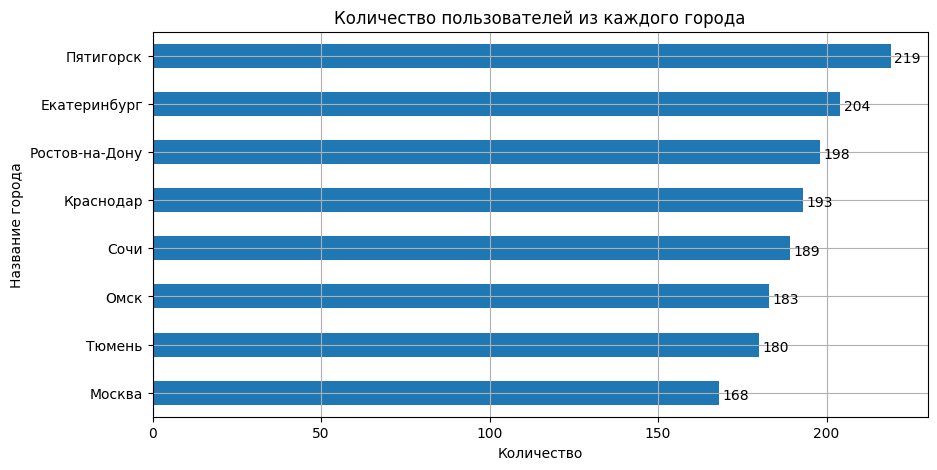

In [22]:
city_counts_users = users['city'].value_counts().sort_values()
ax = city_counts_users.plot.barh(figsize=(10,5),title='Количество пользователей из каждого города', grid=True)

for index, value in enumerate(city_counts_users):
    ax.text(value + 5,index-0.2, str(value), ha='center', va='bottom')

plt.ylabel('Название города')
plt.xlabel('Количество')
plt.show()

Отсюда видно, что большинство пользователей из Пятегорска, а меньше всего из Москвы

Можно также рассмотреть график по количеству поездок в каждом городе

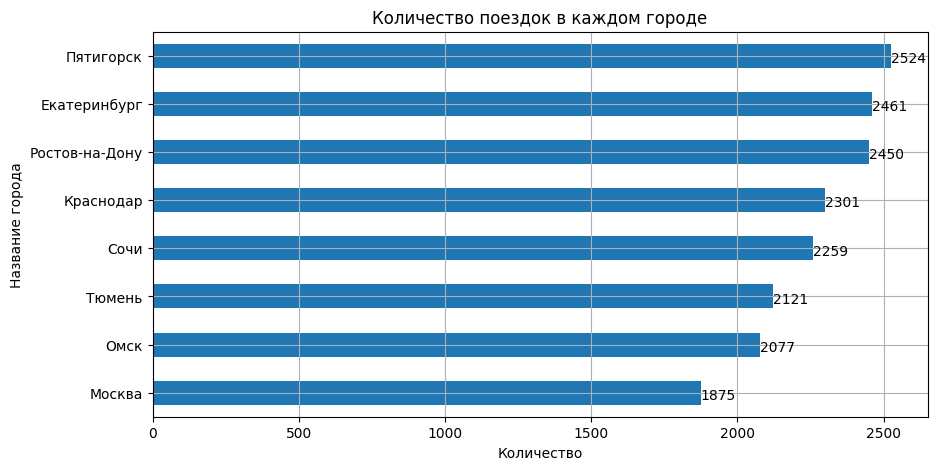

In [23]:
city_counts_rides = pd.merge(rides, users, on='user_id').groupby('city').size().sort_values()
ax = city_counts_rides.plot.barh(figsize=(10,5),title='Количество поездок в каждом городе', grid=True)

for index, value in enumerate(city_counts_rides):
    ax.text(value + 60,index-0.2, str(value), ha='center', va='bottom')

plt.ylabel('Название города')
plt.xlabel('Количество')
plt.show()

Этот график в целом схож с предыдущим, но есть различия. Так в городе Тюмень меньше зарегестрированных пользователей, но больше поездок, по сравнению с городом Омск, где ситуация обратная.

##### Соотношение пользователей с подпиской и без подписки;

Рассмотрим количество пользователей с подпиской и без:
Посчитаем количество пользователей с каждым типом подписки и высчитаем их долю от общего числа пользователей

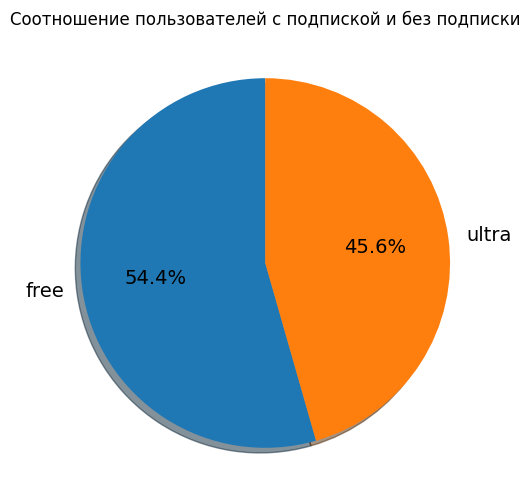

In [24]:
grouped_subscription_type = users['subscription_type'].value_counts()
percent_subscription_type = grouped_subscription_type / grouped_subscription_type.sum() * 100
ax = percent_subscription_type.plot.pie(figsize=(8, 6),
                                        autopct='%1.1f%%',
                                        startangle=90,
                                        textprops={'fontsize': 14},
                                        shadow=True)

plt.title('Соотношение пользователей с подпиской и без подписки')
plt.ylabel('')

plt.show()

Из этого графика видно: 

Преобладают пользователи без подписки(54% от общего числа) над теми, у которых подписка есть (46% от общего числа)

##### Возраст пользователей

Рассмотрим количество количество пользователей каждого возраста

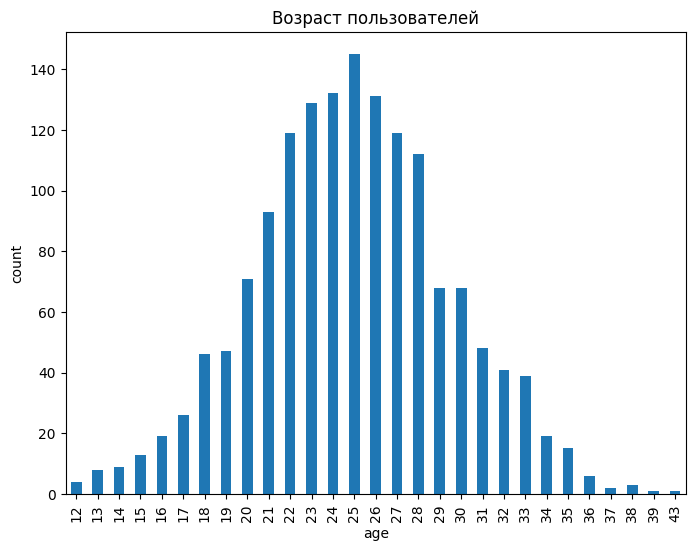

In [25]:
users.groupby('age').size().plot.bar(figsize = (8,6));
plt.title('Возраст пользователей')
plt.ylabel('count')
plt.xlabel('age')
plt.show()

Согласно этой гистограмме большинство пользователей приходится на возраст от 15 до 35 лет.

Расчитаем процент этих пользователей от общего числа

In [26]:
print('От 15 до 35: ',round(len(users.query('age>=15 and age<=35'))/len(users)*100,2),'%')

От 15 до 35:  97.78 %


На эту категорию приходится практически 98% пользователей

In [27]:
print('От 20 до 30: ', round(len(users.query('age>=20 and age<=30'))/len(users)*100,2),'%')

От 20 до 30:  77.38 %


И более 77% приходится на пользователей от 20 до 30

Рассмотрим также общую информацию о возрасте

In [28]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Согласно этому средний возраст составляет около 25 лет, приэтом он практически совпадает с медианным, а значит выбросов данных нет или они незначительны

Рассмотрим различается ли возраст пользователей в зависимости от города.

Построим гистограммы и сравним средние и медианные значения

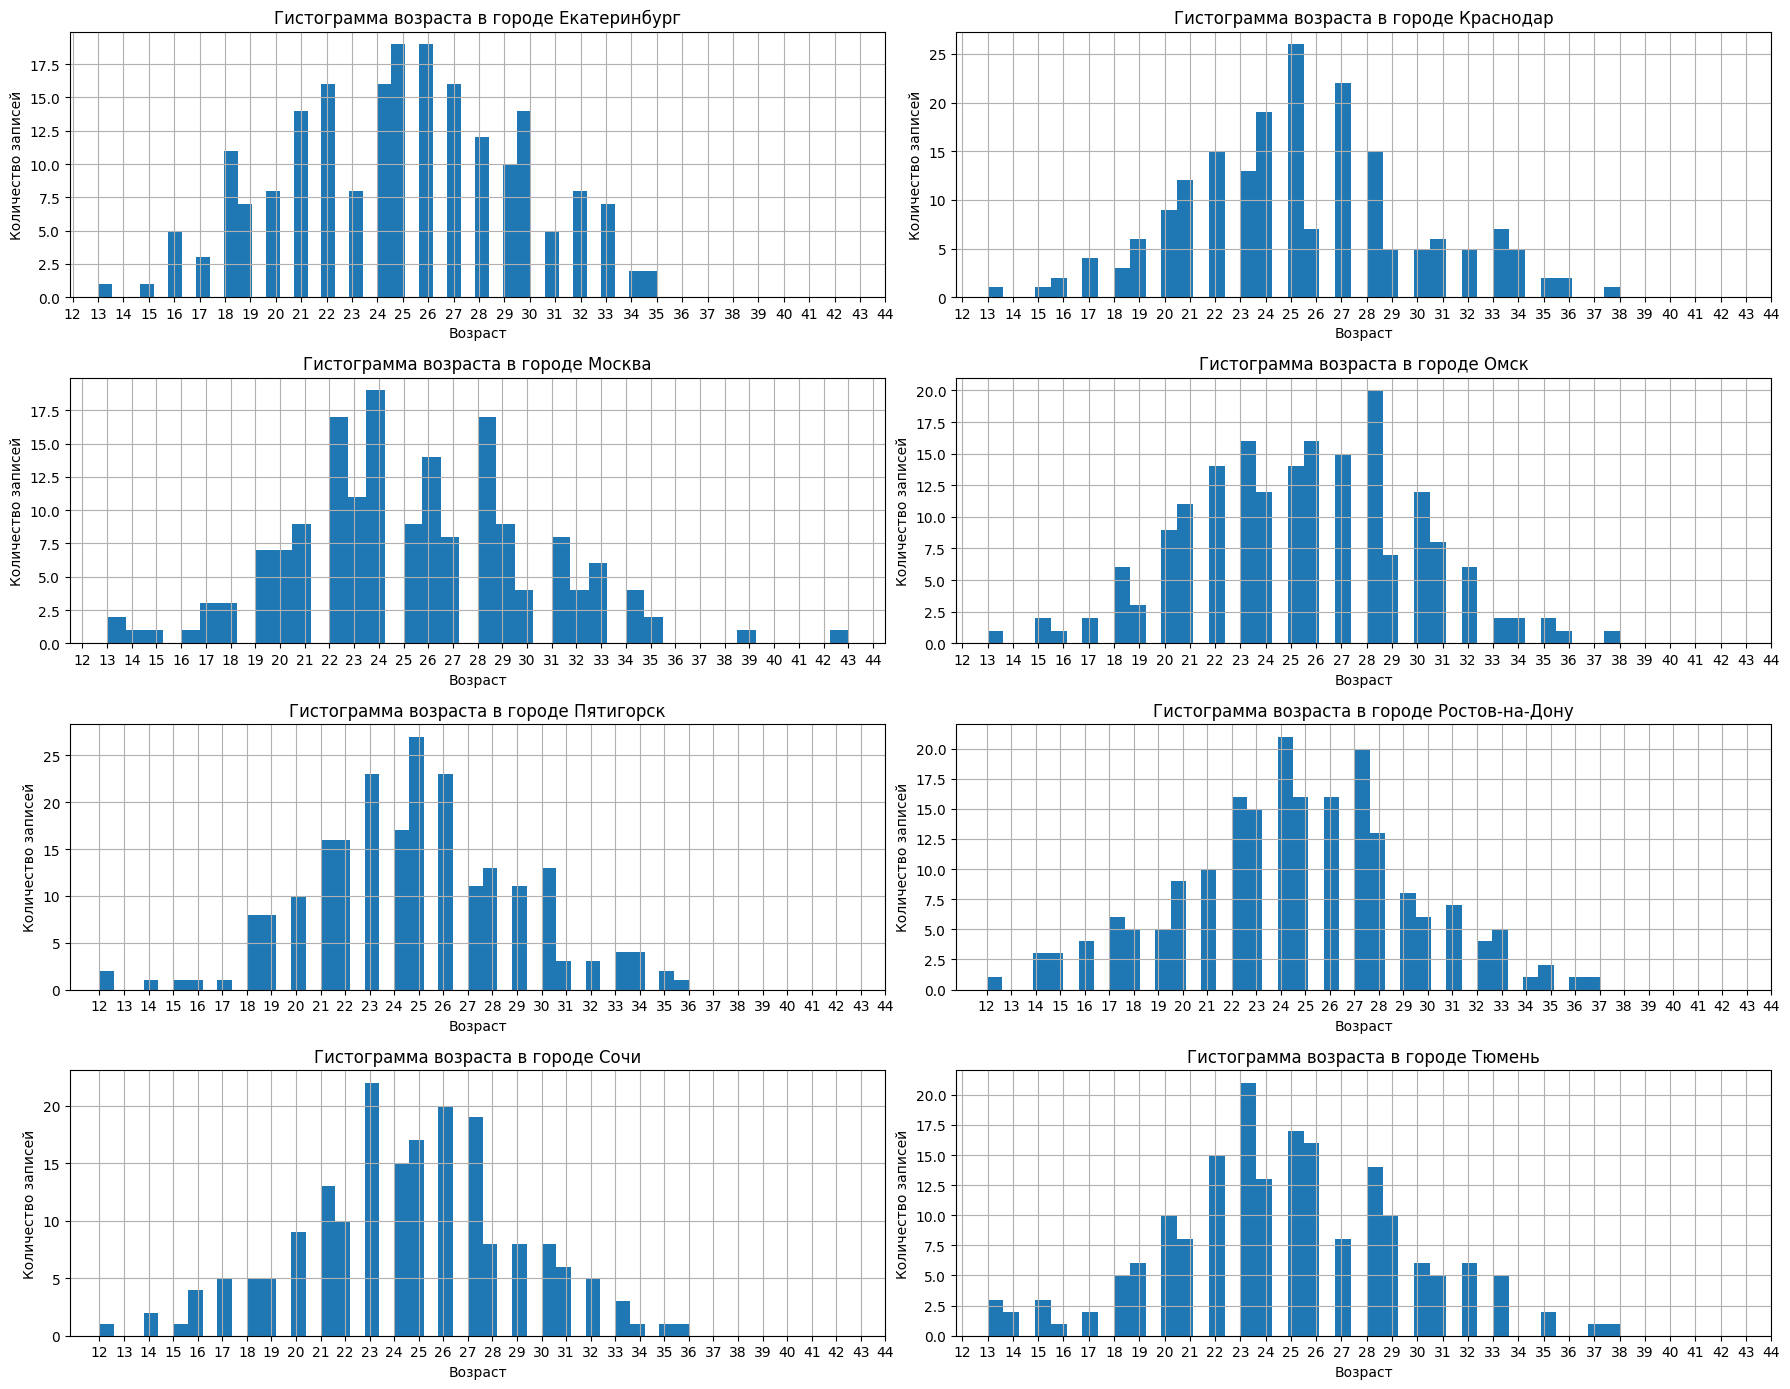

In [29]:
grouped = users.groupby('city')

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18, 14))
for (i, (city, group)), ax in zip(enumerate(grouped), axes.flatten()):
    group['age'].hist(bins=40, ax=ax)
    ax.set_title(f'Гистограмма возраста в городе {city}')
    ax.set_xlabel('Возраст')
    ax.set_ylabel('Количество записей')
    ax.set_xticks(range(12,45))
plt.tight_layout()
plt.show()

In [30]:
grouped['age'].agg(['mean','median']).sort_values(by='mean')

,mean,median
city,,
Сочи,24.507937,25.0
Ростов-на-Дону,24.545455,25.0
Тюмень,24.638889,25.0
Пятигорск,24.716895,25.0
Екатеринбург,24.955882,25.0
Москва,25.267857,25.0
Краснодар,25.290155,25.0
Омск,25.382514,26.0


В целом значения по городам отличаются не более чем на 1 год.

Отличился город Омск, который показывает самые большие значения по возрасту, где половина выборки приходится на 26 лет, в отличие от других городов где медианных возраст 25.

##### Расстояние, которое пользователь преодолел за одну поездку;

Построим гистограмму расстояний пользователей за однй поездку

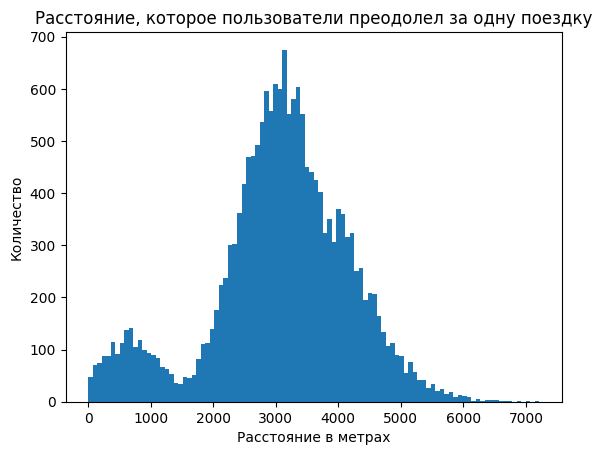

In [31]:
rides['distance'].plot.hist(bins=100);
plt.title('Расстояние, которое пользователи преодолел за одну поездку')
plt.ylabel('Количество')
plt.xlabel('Расстояние в метрах')
plt.show()

In [32]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

На этой гистограмме наблюдается два пика в 0.8 км и 3.1 км и спад в районе 1.5 км.
При анализе расстояний скорее всего придется делать 2 среза данных до 1500м и после, так как этот спад никак не специфичен для конкретного города, месяца или вида подписки. Графики подтверждающие это приведены ниже.

In [33]:
merged = pd.merge(rides,users,on='user_id')

group_city = merged.groupby('city')
group_month = merged.groupby('month')
group_sub_type = merged.groupby('subscription_type')

Данные по городам

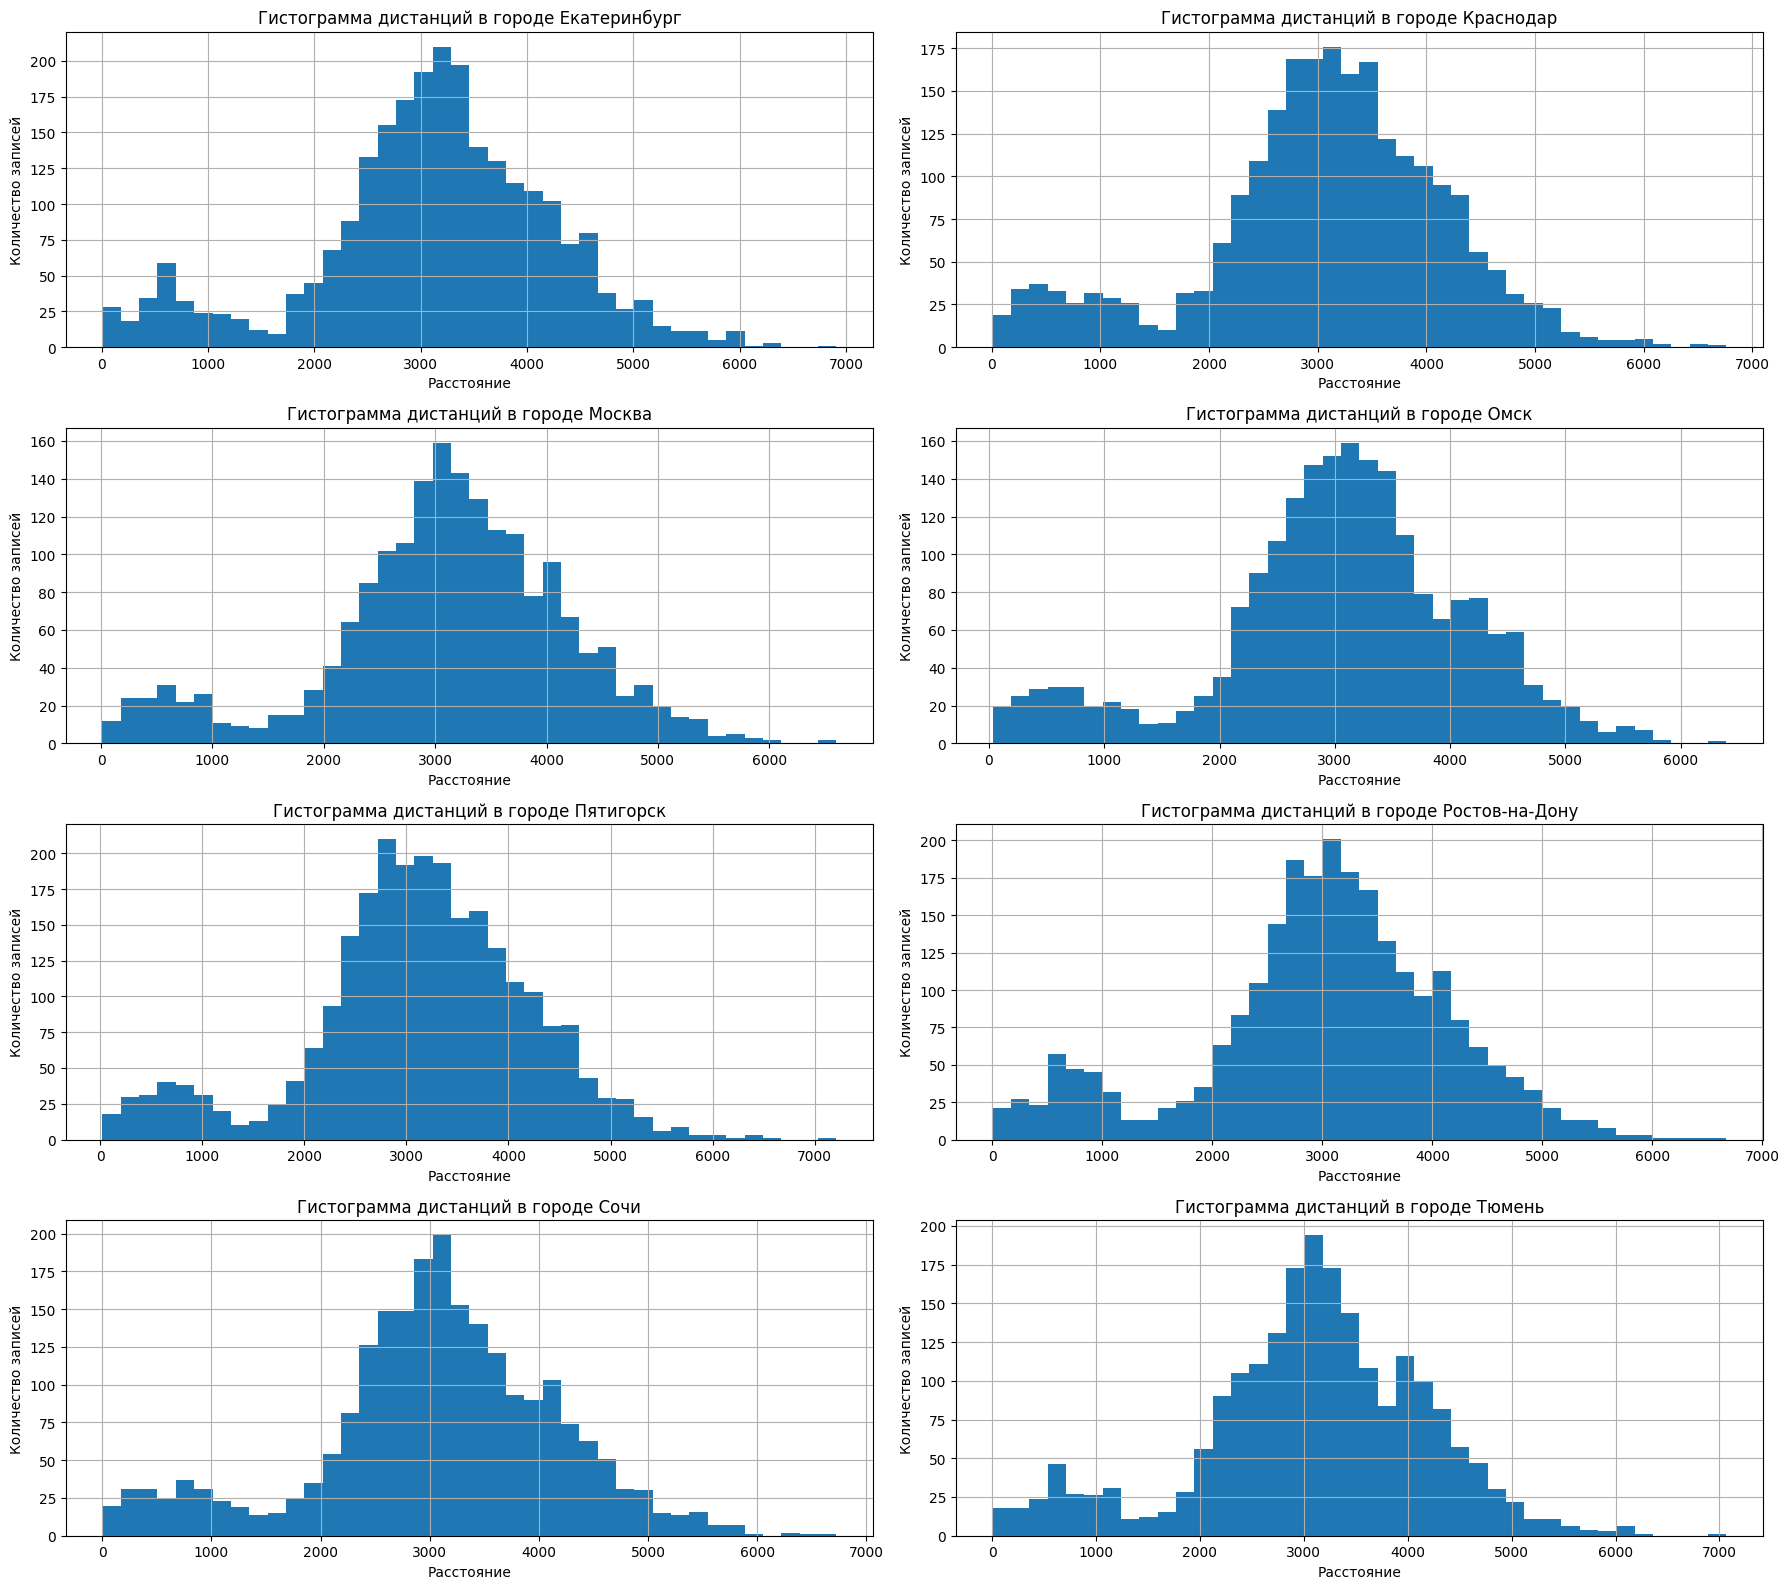

In [34]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18, 16))
for (i, (distance, group)), ax in zip(enumerate(group_city), axes.flatten()):
    group['distance'].hist(bins=40, ax=ax)
    ax.set_title(f'Гистограмма дистанций в городе {distance}')
    ax.set_xlabel('Расстояние')
    ax.set_ylabel('Количество записей')
plt.tight_layout()
plt.show()

Данные по месяцам

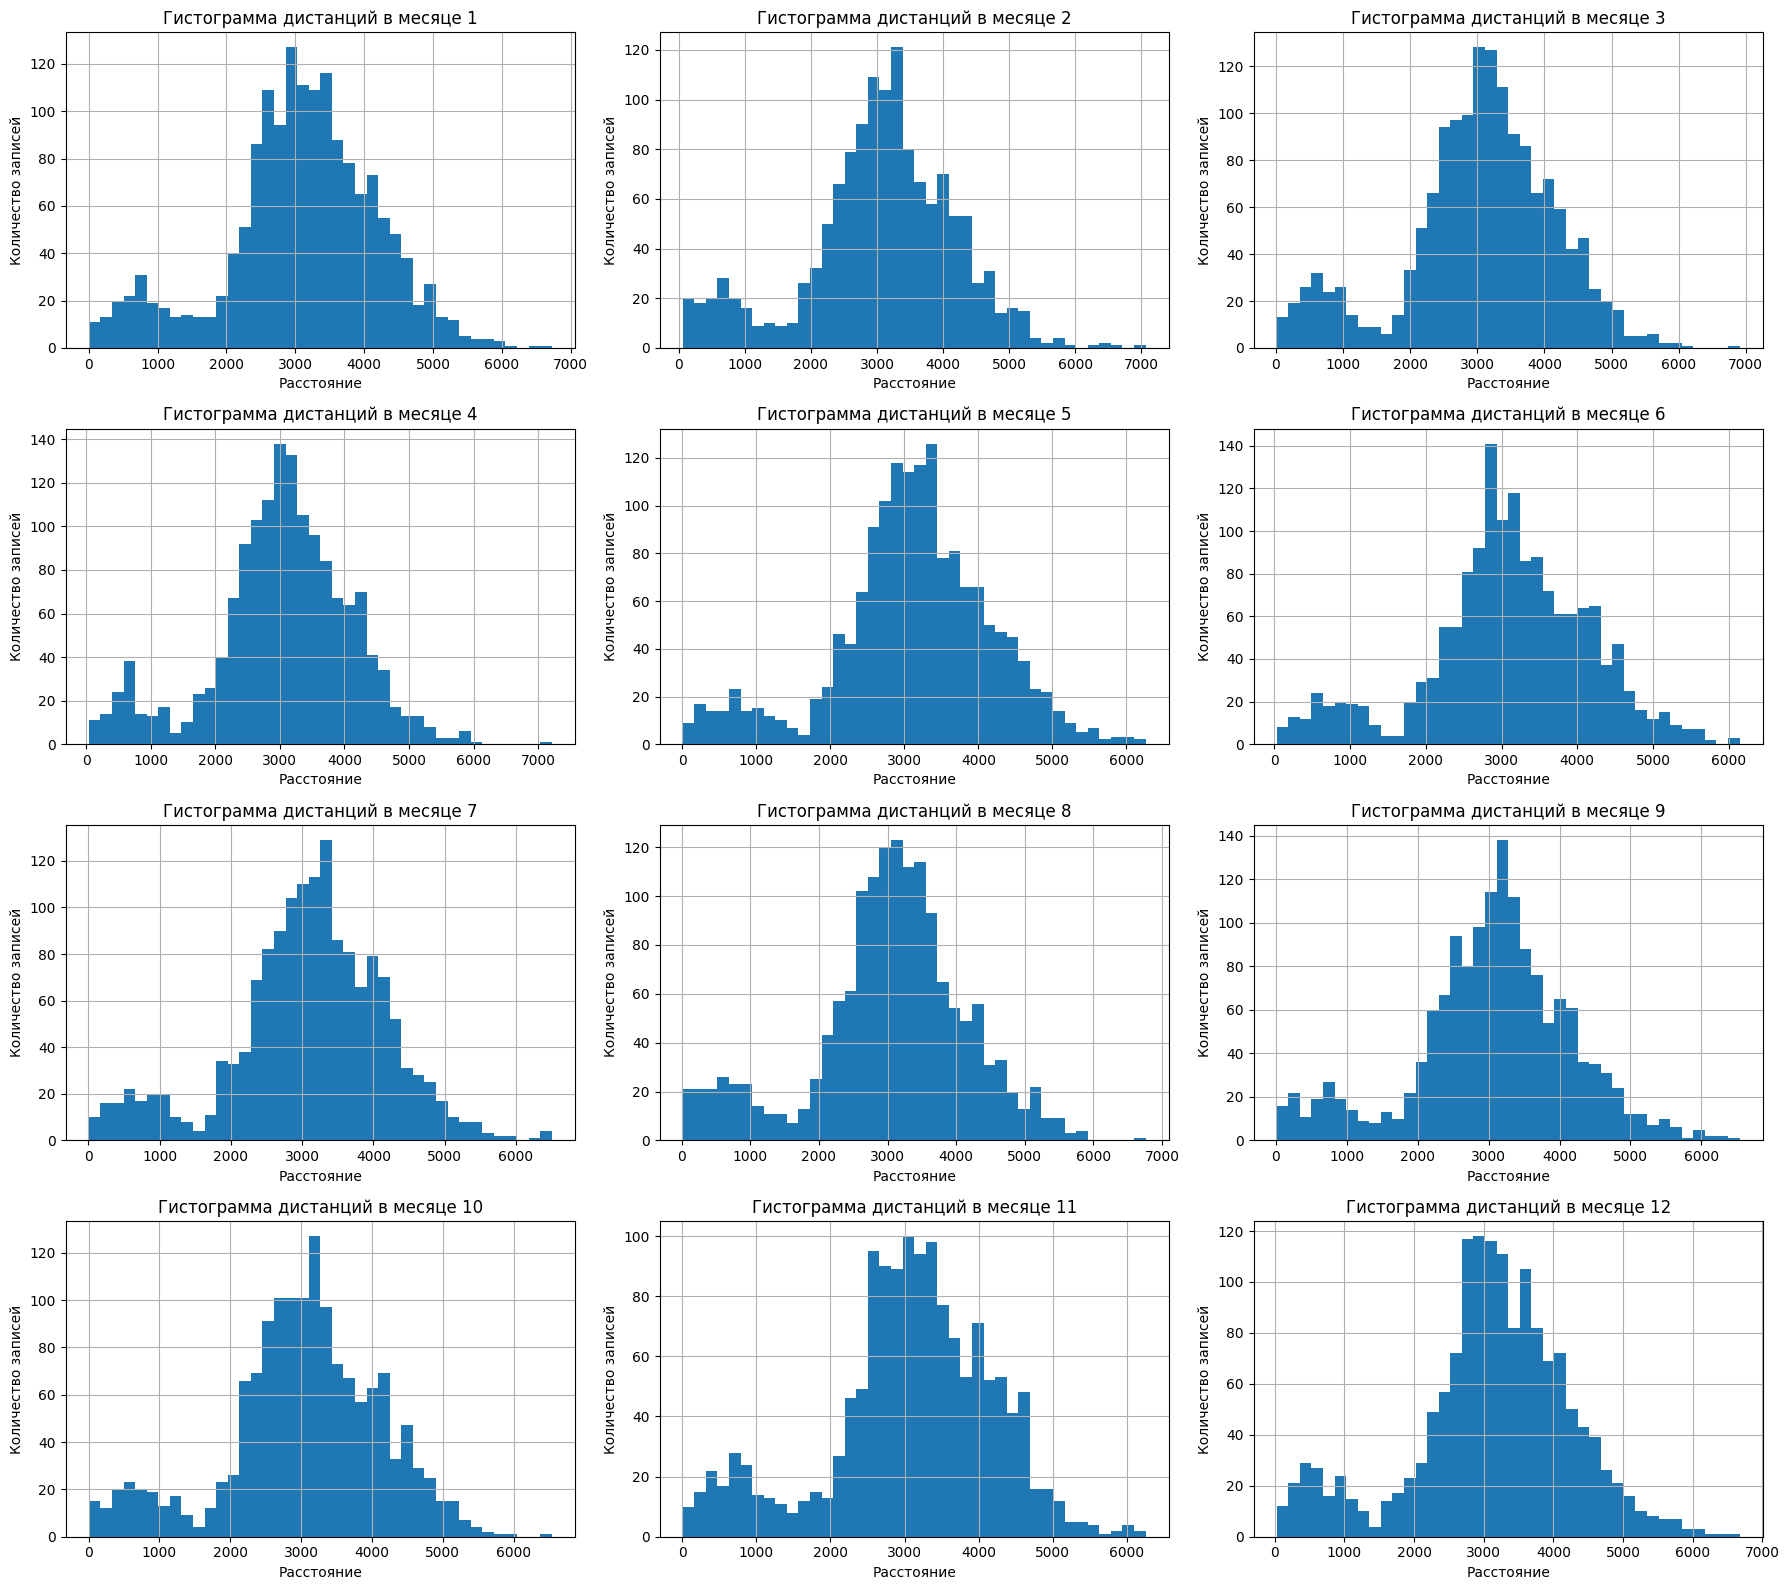

In [35]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 16))
for (i, (month, group)), ax in zip(enumerate(group_month), axes.flatten()):
    group['distance'].hist(bins=40, ax=ax)
    ax.set_title(f'Гистограмма дистанций в месяце {month}')
    ax.set_xlabel('Расстояние')
    ax.set_ylabel('Количество записей')
plt.tight_layout()
plt.show()

Данные по типу подписки

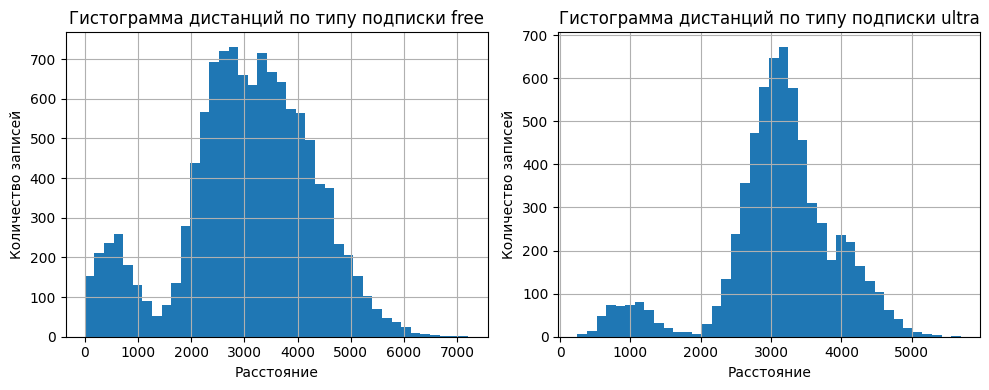

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
for (i, (sub_type, group)), ax in zip(enumerate(group_sub_type), axes.flatten()):
    group['distance'].hist(bins=40, ax=ax)
    ax.set_title(f'Гистограмма дистанций по типу подписки {sub_type}')
    ax.set_xlabel('Расстояние')
    ax.set_ylabel('Количество записей')
plt.tight_layout()
plt.show()

Хотя в бесплатном типе подписке расстояния до 1500 больше чем в платной, однако по бесплатной подписке также ездят и на длинные расстояния. Интересно что имеется небольшой спад в самом центре на расстоянии 3км, то есть пик на этих значениях в исходной гистограмме, как раз таки формируется из записей платной подписки.

Рассмотрим возможную зависимость между временем и расстоянием на первой, второй части выборки и всей выборке

Меньше 1500:  0.35029592068566107


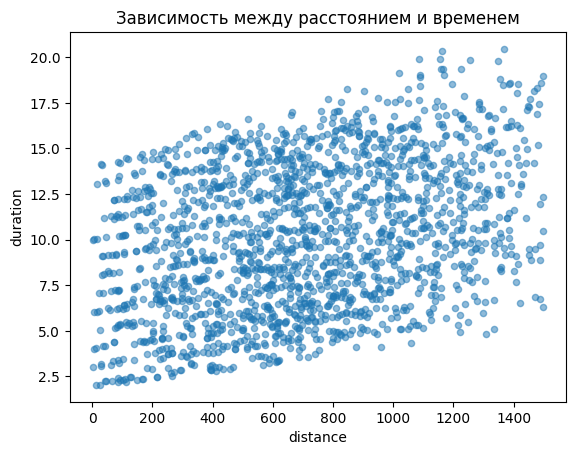

In [37]:
print('Меньше 1500: ', rides.query('distance<1500')['distance'].corr(rides['duration']))
(rides
 .query('distance<1500')
 .plot(x='distance',y='duration',kind='scatter',alpha=0.5,title='Зависимость между расстоянием и временем')
);

Больше 1500:  0.3794559422687556


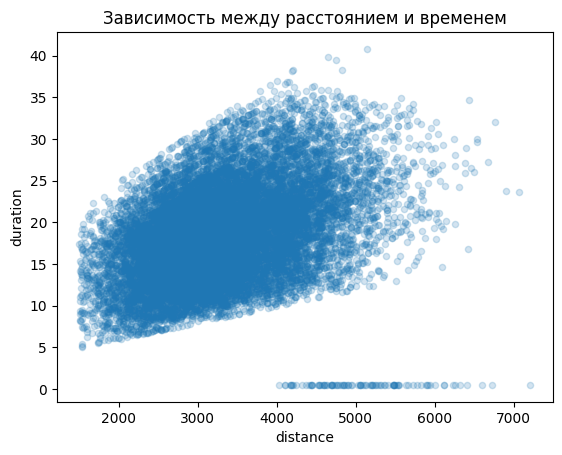

In [38]:
print('Больше 1500: ',rides.query('distance>1500')['distance'].corr(rides['duration']))
(rides
 .query('distance>1500')
 .plot(x='distance',y='duration',kind='scatter',alpha=0.2,title='Зависимость между расстоянием и временем')
);

Вся выборка:  0.5367776552505346


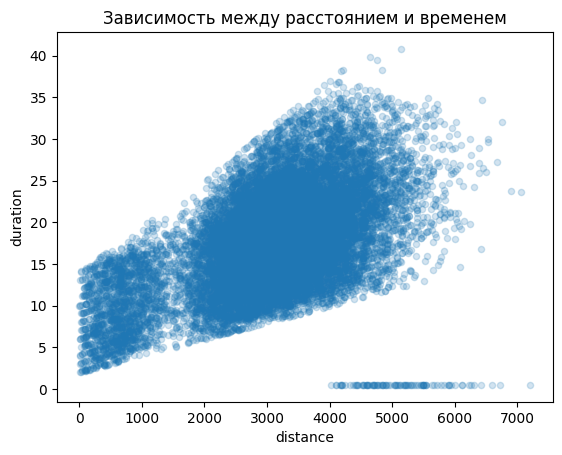

In [39]:
print('Вся выборка: ',rides['distance'].corr(rides['duration']))
rides.plot(x='distance',y='duration',kind='scatter',alpha=0.2,title='Зависимость между расстоянием и временем');

Отсюда видно что если анализировать все данные слабая корреляция все-таки имеется, однако для расстояний отдельно меньше и больше 1500 корреляция практически отсутвует. Скорее всего зависимость между временем и расстоянием имеет более сложный характер.

Кроме того имеются аномальные значения для времени (огромные значения расстояния при 0 секунд длительности), которые мы удалим позже.

In [40]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Таким образом, среднее расстояние составляет около 3070 метров, при этом наблюдается пик на расстоянии 800 метров, затем снижение вплоть до 1500 метров и вновь рост поездок вплоть до пикового значения в примерно 3200 метров.

##### Продолжительность поездок.

Проанализируем продолжительность поездок:
Сначала построим общую гистограмму

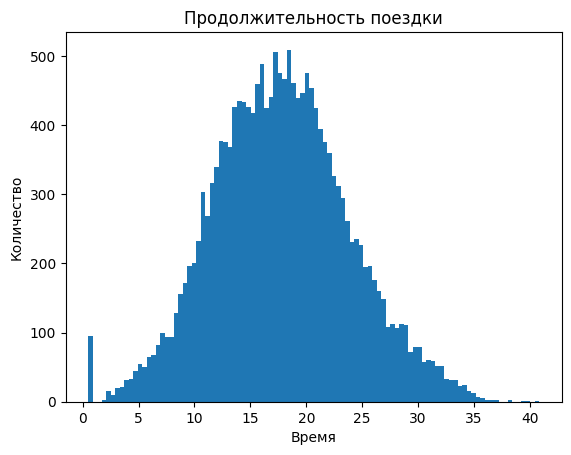

In [41]:
rides['duration'].plot.hist(bins=100);
plt.title('Продолжительность поездки')
plt.xlabel('Время')
plt.ylabel('Количество')
plt.show()

Она распределена практически нормально за исключением аномальных значений, где время поездки < 1 минут. Скорее всего в таких случаях пользователь после начала сразу же её отменял. Посмотрим сколько строк с такими данным у нас есть.

In [42]:
len(rides.query('duration<1'))

95

Выведем значение расстояния для таких поездок:

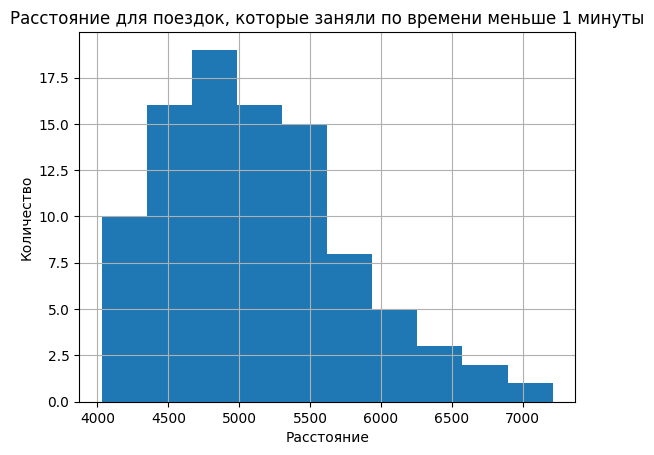

In [43]:
rides.query('duration<1 and duration>0')['distance'].hist();
plt.title('Расстояние для поездок, которые заняли по времени меньше 1 минуты')
plt.xlabel('Расстояние')
plt.ylabel('Количество')
plt.show()

Такие данные - ненормальны: чтобы проехать 4 или 7 километров меньше чем за 1 минуту, скорость самоката должна быть равна 240 или 420 км/ч - что примерно равняется скорости самолета. Если бы нам были известны ограничения самоката по скорости, мы могли бы рассчитать примерное реальное время для этого расстояния и посчитать сколько выручки эти пользователи принесли, однако на этот счет нам ничего не известно, исправить данные корретно мы не можем, соответственно рассчитать выручку для этих 95 поездок мы не можем, а на общий анализ эти данные не повлияют, потому что их немного ~0.5% от общего числа, поэтому мы имеем право их удалить.

In [44]:
rides = rides.query('duration>1')

Снова выведем гистограмму

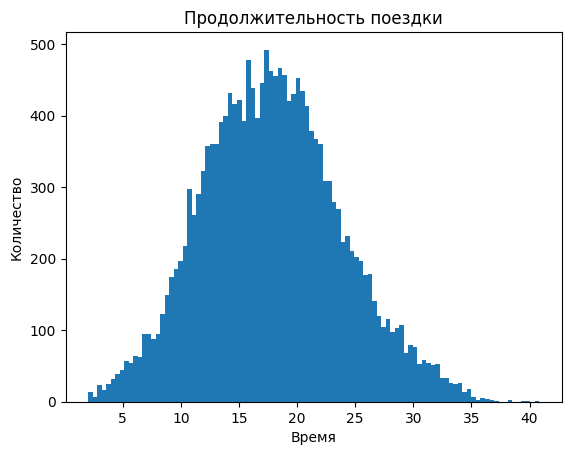

In [45]:
rides['duration'].plot.hist(bins=100);
plt.title('Продолжительность поездки')
plt.xlabel('Время')
plt.ylabel('Количество')
plt.show()

In [46]:
rides['duration'].describe()

count    17973.000000
mean        17.896480
std          5.975424
min          2.035632
25%         13.670439
50%         17.714122
75%         21.747016
max         40.823963
Name: duration, dtype: float64

In [47]:
len(rides.query('duration < 30'))/len(rides)

0.9697880153563679

Таким образом среднее продолжительность в пути составляет около 18 минут, при этом практически 97% поездок составляет менее получаса.

**Вывод**

+ Больше всего пользователей сервиса проживают в городах Пятигорск и Екатеринбург, а меньше всего в Москве и Тюмени. Однако по количеству поездок в городах Омск менее популярный, хотя пользователей там больше.
+ Преобладают пользователи без подписки(54% от общего числа) над теми, у которых подписка есть (46% от общего числа)
+ Большинство пользователей приходится на возраст от 15 до 35 лет (97,7% от общей выборки), из них большинство составляет молодые люди от 20 до 30 лет (77,4% от общей выборки). При этом средний возраст по городам несильно отличается и составляет примерно 25 лет, при этом наиболее возрастным оказался Омск, а самым молодым Сочи.
+ Среднее расстояние составляет около 3070 метров, при этом наблюдается пик на расстоянии 800 метров, затем снижение вплоть до 1500 метров и вновь рост поездок вплоть до пикового значения в примерно 3200 метров. Факторы влияющие на такое распределение расстояний выявлено не было.
Была также выявлена слабая корреляция между временем и расстоянием.
+ На гистограмме времени были выявлены аномальные по длинне поездки составляющие менее 1 минут, которые в последствии были удалены из выборки. Также была рассчитана средняя продолжительность в пути - около 18 минут, при этом практически 97% поездок составляет менее получаса.


#### Шаг 4. Объединение данных

##### Объединение таблиц

Объединим данные в одну таблицу. Сначала rides и users по столбцу user_id. Затем новую таблицу и subscriptions по типу подписки.

In [48]:
df = pd.merge(rides,users,on='user_id')
df = pd.merge(df,subscriptions,on='subscription_type')

Выведем первые 5 строк новой таблицы

In [49]:
df.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


Проверим новый датафрейм на корректность объединения. Так как мы соединяли по таблице rides, количество записей в исходном и новом датафрейме должно совпадать

In [50]:
print('Общая информация о новой таблице df \n')
df.info()

Общая информация о новой таблице df 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   distance           17973 non-null  float64       
 2   duration           17973 non-null  float64       
 3   date               17973 non-null  datetime64[ns]
 4   month              17973 non-null  int32         
 5   name               17973 non-null  object        
 6   age                17973 non-null  int64         
 7   city               17973 non-null  object        
 8   subscription_type  17973 non-null  object        
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 

In [51]:
print('Общая информация о таблице rides \n')
rides.info()

Общая информация о таблице rides 

<class 'pandas.core.frame.DataFrame'>
Index: 17973 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   17973 non-null  int64         
 1   distance  17973 non-null  float64       
 2   duration  17973 non-null  float64       
 3   date      17973 non-null  datetime64[ns]
 4   month     17973 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 772.3 KB


Отсюда видно, что данные были объедены корректно, количество записей совпадает и пропуски или лишние записи не появились

##### Создание новых таблиц

Создадим таблицу df_off - с пользователями без подписки

In [52]:
df_off = df.query('subscription_type == "free"')

In [53]:
df_off.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


Создадим таблицу df_on - с пользователями c подпиской

In [54]:
df_on = df.query('subscription_type == "ultra"')

In [55]:
df_on.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


Проверим совпадает ли количество записей отфильтрованных датафреймов с исходным

In [56]:
print(len(df),'равно?',len(df_on),'+',len(df_off),'=',len(df_on)+len(df_off))

17973 равно? 6500 + 11473 = 17973


Количество записей совпадает, данные были отфильтрованы корректно.

##### Визуализация информации о расстоянии и времени поездок для пользователей 

Постоим гистограммы для расстояния пользователей без подписки и с ней

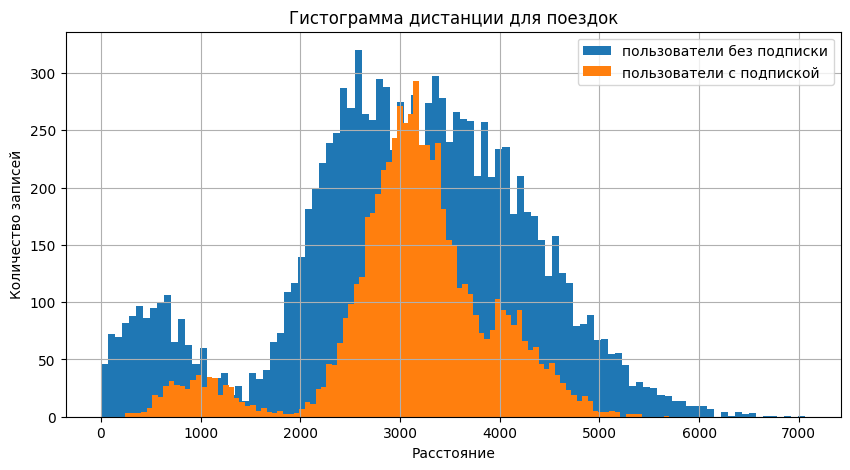

In [57]:
df_off['distance'].hist(bins=100,label='пользователи без подписки',figsize=(10,5))
df_on['distance'].hist(bins=100,label='пользователи с подпиской',figsize=(10,5))
plt.title('Гистограмма дистанции для поездок')
plt.xlabel('Расстояние')
plt.ylabel('Количество записей')
plt.legend(loc='upper right')
plt.show()

In [58]:
agg_off = df_off['distance'].agg(['min','mean','median','std','max'])
agg_on = df_on['distance'].agg(['min','mean','median','std','max'])

agg_off.name = 'free'
agg_on.name = 'ultra'

pd.concat([agg_off, agg_on], axis=1).round(2)

,free,ultra
min,0.86,244.21
mean,3028.37,3115.45
median,3102.08,3148.64
std,1235.54,836.90
max,7066.00,5699.77


Согласно последней сводной таблице и среднее и медианное значения расстояния пользователей с подпиской больше, чем без неё. Также данные в таблице с подпиской имеют куда меньший разброс чем без подписки.

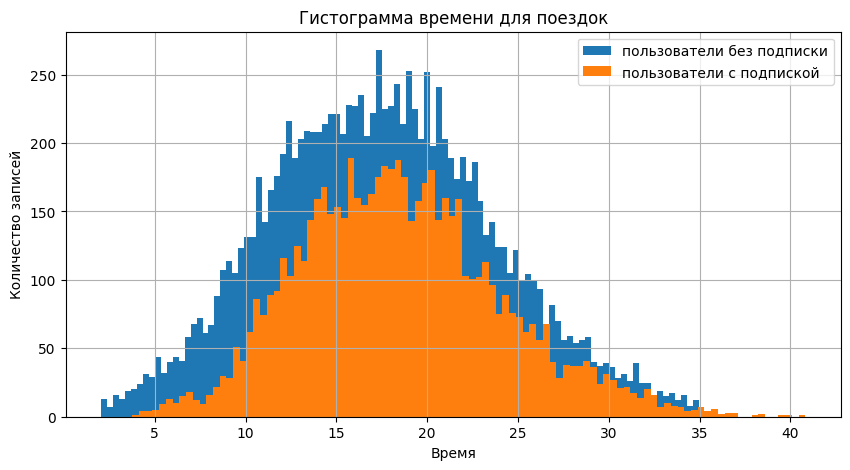

In [59]:
df_off['duration'].hist(bins=100,label='пользователи без подписки',figsize=(10,5))
df_on['duration'].hist(bins=100,label='пользователи с подпиской',figsize=(10,5))
plt.title('Гистограмма времени для поездок')
plt.xlabel('Время')
plt.ylabel('Количество записей')
plt.legend(loc='upper right')
plt.show()

In [60]:
agg_off = df_off['duration'].agg(['min','mean','median','std','max'])
agg_on = df_on['duration'].agg(['min','mean','median','std','max'])

agg_off.name = 'free'
agg_on.name = 'ultra'

pd.concat([agg_off, agg_on], axis=1).round(2)

,free,ultra
min,2.04,3.76
mean,17.53,18.54
median,17.38,18.18
std,6.16,5.57
max,34.95,40.82


На гистограмме времени наблюдается аналогичная ситуация. Пользователи с подпиской тратят в среднем больше времени в дороге чем пользователи без неё и разброс данных меньше.

#### Шаг 5. Подсчёт выручки

##### Создание датафрейма с суммарным расстоянием, поездками, временем для каждого пользователя за каждый месяц

In [61]:
df['duration'] = np.ceil(df['duration'])
grouped = df.groupby(['user_id', 'month'])

df_agg = pd.DataFrame(columns=['rides_count','sum_distance','sum_duration'])

df_agg['rides_count'] = grouped.size()
df_agg['sum_distance'] = grouped['distance'].sum().round(2)
df_agg['sum_duration'] = grouped['duration'].sum()

In [62]:
df_agg.head(12)

rides_count  sum_distance  sum_duration
user_id month                                         
1       1                2       7027.51          42.0
        4                1        754.16           7.0
        8                2       6723.47          46.0
        10               2       5809.91          32.0
        11               3       7003.50          56.0
        12               2       6751.63          28.0
2       3                3      10187.72          63.0
        4                2       6164.38          40.0
        6                1       3255.34          14.0
        7                2       6780.72          48.0
        8                1        923.01           7.0
        10               1       2824.64          19.0

#####  Создание столбца с помесячной выручкой, которую принёс каждый пользователь.

Помесячная выручка считается по формуле: стоимость старта поездки x количество поездок + стоимость одной минуты поездки x общая продолжительность всех поездок в минутах + стоимость подписки.

Сначала добавим в таблицу новые столбцы из df с информацией об их подписке: цена старта, цена за минуту и цена подписки

In [63]:
df_agg = pd.merge(df_agg, df.groupby('user_id')[['minute_price','start_ride_price','subscription_fee']].first(),
                  left_index=True, right_index=True)

In [64]:
df_agg.head(10)

rides_count  sum_distance  sum_duration  minute_price  \
user_id month                                                          
1       1                2       7027.51          42.0             6   
        4                1        754.16           7.0             6   
        8                2       6723.47          46.0             6   
        10               2       5809.91          32.0             6   
        11               3       7003.50          56.0             6   
        12               2       6751.63          28.0             6   
2       3                3      10187.72          63.0             6   
        4                2       6164.38          40.0             6   
        6                1       3255.34          14.0             6   
        7                2       6780.72          48.0             6   

               start_ride_price  subscription_fee  
user_id month                                      
1       1                     0               199  
        4                     0               199  
        8                     0               199  
        10                    0               199  
        11                    0               199  
        12                    0               199  
2       3                     0               199  
        4                     0               199  
        6                     0               199  
        7                     0               199

Рассчитаем столбец по формуле

In [65]:
df_agg['income'] = (
    df_agg['start_ride_price'] * df_agg['rides_count'] +
    df_agg['minute_price'] * df_agg['sum_duration'] +
    df_agg['subscription_fee']
)

Выведем датафрейм с новым столбцом

In [66]:
df_agg.head(6)

rides_count  sum_distance  sum_duration  minute_price  \
user_id month                                                          
1       1                2       7027.51          42.0             6   
        4                1        754.16           7.0             6   
        8                2       6723.47          46.0             6   
        10               2       5809.91          32.0             6   
        11               3       7003.50          56.0             6   
        12               2       6751.63          28.0             6   

               start_ride_price  subscription_fee  income  
user_id month                                              
1       1                     0               199   451.0  
        4                     0               199   241.0  
        8                     0               199   475.0  
        10                    0               199   391.0  
        11                    0               199   535.0  
        12                    0               199   367.0

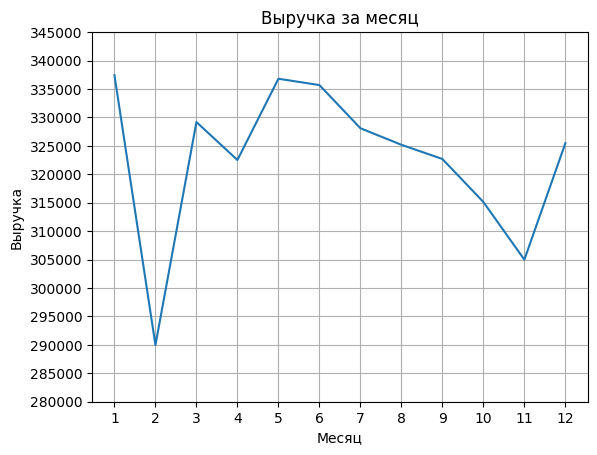

In [67]:
monthly_income = df_agg.groupby(level='month')['income'].sum()
ax = monthly_income.plot.line(title = 'Выручка за месяц',grid=True);
ax.set_xlabel('Месяц')
ax.set_ylabel('Выручка')
ax.set_yticks(range(280000, 350000, 5000))
ax.set_xticks(range(1,13))
plt.show()

Таким образом, наименеее прибыльним оказались месяцы февраль и ноябрь, а наиболее прибыльными январь, май и июнь. 

#### Шаг 6. Проверка гипотез

##### Тратят ли пользователи с подпиской больше времени на поездки?
Если да, то пользователи с подпиской могут быть «выгоднее» для компании.

Для начала нужно определить нулевую и альтернативную гипотезы:

+ H0: Среднее время в поездке у пользователей с подпиской = Среднего времени в поездке у пользователей без подписки
+ H1: Среднее время в поездке у пользователей с подпиской > Среднего времени в поездке у пользователей без подписки

Сначала рассчитаем среднее для двух выборок:

In [68]:
print('Среднее для пользователей c подпиской:', df_on['duration'].mean().round(2))
print('Среднее для пользователей без подписки:', df_off['duration'].mean().round(2))

Среднее для пользователей c подпиской: 18.54
Среднее для пользователей без подписки: 17.53


Уровень статистической значимости определим как 0.05 и рассчитаем p-value для нашей гипотезы

In [69]:
alpha = 0.05
result = st.ttest_ind(
    df_on['duration'],
    df_off['duration'],
    alternative='greater'
)
print("p-value: ", result.pvalue)

p-value:  4.7044680744539e-28


Сделаем вывод об отвержени или неотвержении нулевой гипотезы:

In [70]:
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Отвергаем нулевую гипотезу


**Нулевая гипотеза** - среднее время в поездке у пользователей с подпиской = среднему времени в поездке у пользователей без подписки - **отвергнута**, значит мы можем допустить, что пользователи с подпиской все же выгоднее чем пользователи без подписки 

##### Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката.

Для начала нужно определить нулевую и альтернативную гипотезы:

+ H0: Среднее расстояние одной поездки у пользователей с подпиской <= 3130
+ H1: Среднее расстояние одной поездки у пользователей с подпиской > 3130

Выведем среднее расстояние

In [71]:
print('Среднее расстояние для пользователей c подпиской:', df_on['distance'].mean().round(2))

Среднее расстояние для пользователей c подпиской: 3115.45


In [72]:
alpha = 0.05
result = st.ttest_1samp(
    df_on['distance'],
    3130,
    alternative='greater'
)
print("p-value: ", result.pvalue)

p-value:  0.9195368847849785


Сделаем вывод об отвержени или неотвержении нулевой гипотезы:

In [73]:
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

Не отвергаем нулевую гипотезу


**Нулевая гипотеза** - среднее расстояние одной поездки у пользователей с подпиской <= 3130 - **не отвергнута**, значит мы можем допустить, что пользователи с подпиской в среднем проезжают меньше 3130 метров,что с точки зрения износа самоката оптимально - в пределах нормы.

##### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Для начала нужно определить нулевую и альтернативную гипотезы:

+ H0: Средняя выручка у пользователей с подпиской = чем выручка от пользователей без подписки
+ H1: Средняя выручка у пользователей с подпиской > чем выручка от пользователей без подписки

Проверим наши гипотезы

In [74]:
alpha = 0.05
result = st.ttest_ind(
    df_agg.query('subscription_fee==199')['income'],
    df_agg.query('subscription_fee==0')['income'],
    alternative='greater'
)
print("p-value: ", result.pvalue)

p-value:  2.0314113674863288e-30


Сделаем вывод об отвержени или неотвержении нулевой гипотезы:

In [75]:
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

Отвергаем нулевую гипотезу


**Нулевая гипотеза** -  средняя выручка у пользователей с подпиской = чем выручка от пользователей без подписки - **отвергнута**, значит мы можем допустить, средняя выручка у пользователей с подпиской больше чем выручка от пользователей без подписки.

#### ВЫВОД:

Подведем итоги анализа:

Были загружены данные о пользователях, поездках и подписках в соответсвующие таблицы users, rides,subscriptions

**Предобработка данных:**
+ В столбце date в таблицы rides был изменен тип на datetime
+ Был создан новый столбец month в rides, где указан месяц совершения поездки
+ Были удалены полные дубликаты из таблицы users и соответвующие им строки в таблице rides
+ Были удалены неявные дубликаты в столбце name таблицы users, например Наташа была преобразована в Наталья
+ Пропусков обнаружено не было

**Исследовательский анализ:**

+ Частота встречаемости городов: 

Анализ показал, что больше всего пользователей сервиса проживают в городах Пятигорск и Екатеринбург, а меньше всего в Москве и Тюмени. Однако по количеству поездок в городах Омск менее популярный, хотя пользователей там больше.

+ Соотношение пользователей с подпиской и без подписки

Анализ показал, что пользователей без подписки больше чем пользователей с ней, и их доля от общего числа составляет соотвественно 54% и 46%

+ Возраст пользователей

Анализ показал, что большинство пользователей приходится на возраст от 15 до 35 лет (97,7% от общей выборки), из них большинство составляет молодые люди от 20 до 30 лет (77,4% от общей выборки). При этом средний возраст по городам несильно отличается и составляет примерно 25 лет, при этом наиболее возрастным оказался Омск.

+ Расстояние, которое пользователь преодолел за одну поездку

Среднее расстояние составляет около 3070 метров, при этом наблюдается пик на расстоянии 800 метров, затем снижение вплоть до 1500 метров и вновь рост поездок вплоть до пикового значения в примерно 3200 метров. Факторов влияющих на такое распределение расстояния у поездок выявлено не было.
Была также выявлена слабая корреляция между временем и расстоянием.

+ Продолжительность поездок

В результате анализа, были выявлены аномальные по длинне поездки составляющие менее 1 минут, которые в последние были удалены из выборки.
Также была рассчитана средняя продолжительность в пути- около 18 минут, при этом практически 97% поездок составляет менее получаса.

**Объединение таблиц:**

Была создана общая таблица df для поездок, где указан пользователь и информация о нем, а также информация о его подписке.

Также из данной таблицы были созданы две новые df_on и df_off, разделенные по типу подписки(её наличие и отсутствие)

Визуализированные данные о расстоянии и времени показали, что в среднем пользователи без подписки совершают более короткие и менее продолжительные поездки по времени, однако разброс значений более высокий.

**Подсчет выручки:**

Была создана отдельная таблица df_agg с рассчитанной помесячно выручкой для каждого пользователя за каждый месяц.
Для которых оказалось, что наименеее прибыльные месяцы февраль и ноябрь(290.000 руб), а наиболее прибыльные январь, май и июнь(более 335.000 руб). 

**Проверка гипотез:**

+ Тратят ли пользователи с подпиской больше времени на поездки?

_Нулевая гипотеза_ - среднее время в поездке у пользователей с подпиской = среднему времени в поездке у пользователей без подписки - _отвергнута_, значит мы можем допустить, что пользователи с подпиской все же выгоднее чем пользователи без подписки

+ Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

_Нулевая гипотеза_ - среднее расстояние одной поездки у пользователей с подпиской <= 3130 - _не отвергнута_, значит мы можем допустить, что пользователи с подпиской в среднем проезжают меньше 3130 метров,что с точки зрения износа самоката оптимально - в пределах нормы.

+ Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Нулевая гипотеза - средняя выручка у пользователей с подпиской = чем выручка от пользователей без подписки - отвергнута, значит мы можем допустить, средняя выручка у пользователей с подпиской больше чем выручка от пользователей без подписки.

**Подводя итоги** наиболее выгодными для нас оказываются пользователи с подпиской, так как они с большей вероятностью принесут больше выручке компании, а также в среднем проводят дольше времени в дороге и проходят большие расстояния.